In [47]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
%config Completer.use_jedi = False
import seaborn as sns

from umap import UMAP
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [18]:

sns.set(font_scale = 1.5, style='white',)

In [19]:
df = pd.read_csv('./BinningResults_edit_csv.csv')
dfy = df[[df.columns[1]]]
dfx = df[df.columns[2:]]

In [48]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)



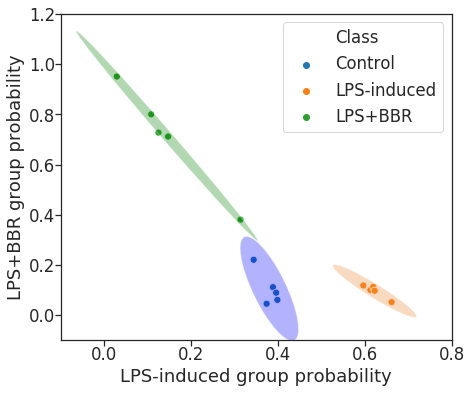

In [100]:
s = abs(df.corr()['Class'])
dfx1 = dfx[s[s > 0.52].index[1:]]
scaler = MinMaxScaler()
dfx1 = pd.DataFrame(scaler.fit_transform(dfx1), 
                   columns = dfx1.columns, 
                   index = dfx1.index)

X = dfx1.values
y = dfy.values

def _get_best_para(X,y):
    # Set up possible values of parameters to optimize over
    parameters = { 'C':[1, 10, 20, 50, 100], 'gamma':[1e-2, 3e-2, 5e-2]}
    svc = SVC(random_state=123, probability = True)
    clf = GridSearchCV(svc, parameters, cv = 3)
    clf.fit(X, y)

    return clf.best_params_

loo = LeaveOneOut()

res = []
true = []
pred = []
for train_index, test_index in loo.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Set up possible values of parameters to optimize over
    best_params_ = _get_best_para(X_train, y_train.ravel())
    clf = SVC(**best_params_, random_state=123, probability = True)
    clf.fit(X_train, y_train.ravel())

    pred_prob = clf.predict_proba(X_test)
    pred_ = clf.predict(X_test)
    res.append(pred_prob)
    pred.append(pred_)
    true.append(y_test)

dfr = pd.DataFrame(pd.DataFrame(np.concatenate(res)))
pred = (dfr.idxmax(axis=1)+1).values


dfp = pd.DataFrame(MinMaxScaler().fit_transform(dfr[[1,2]]))
dfp = dfr[[1,2]]

xyc = ['LPS-induced group probability', 'LPS+BBR group probability']
dfp.columns = xyc
dfp = dfp.join(df['Class'].map({1:'Control', 2:'LPS-induced', 3:'LPS+BBR'}))

fig, ax = plt.subplots(figsize = (7, 6))
sns.scatterplot(x=xyc[0], y=xyc[1], hue='Class', ax = ax,
                palette = 'tab10', style=None, s=50, data=dfp)

dff1 = dfp[dfp.Class == 'Control']
dff2 = dfp[dfp.Class == 'LPS-induced']
dff3 = dfp[dfp.Class == 'LPS+BBR']
confidence_ellipse(dff1[xyc[0]], y=dff1[xyc[1]], n_std=3, facecolor="blue", alpha=0.3, ax =ax)
confidence_ellipse(dff2[xyc[0]], y=dff2[xyc[1]], n_std=4, facecolor="#eb8634", alpha=0.3, ax =ax)
confidence_ellipse(dff3[xyc[0]], y=dff3[xyc[1]], n_std=2, facecolor="green", alpha=0.3, ax =ax)

ax.set_ylim(-0.1,1.2)
ax.set_xlim(-0.1,0.8)


ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.5, )
#sns.despine(top=True, right=True, left=False, bottom=False)


fig.savefig('1.pdf')

In [30]:
dfp['Class_label'] = dfp['Class'].map({'Control':1, 'LPS-induced':2, 'LPS+BBR':3})
dfp.index = df[df.columns[0]]
dfp.to_csv('svm.loocv.csv')